In [60]:
import numpy as np
    
import matplotlib.pyplot as plt
import labellines as ll

from functools import partial

import sys
sys.path.append('../')

from Algorithms import incremental_greedy,no_step_greedy_ball
from utils import RandomUnifBall

import RKHS
from RKHS import GPMI,Gram

import cvxpy as cp

import pickle as pkl
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiment parameters

In [49]:
T = 19

c = 1
l = 1
var_0 = 0.01


search_region_center = np.array([0.,0.])
search_region_radius = 1
step_size = 1

# The reference system.
ref = np.array([[0,0]]) # A single point reference set.
R = np.array([search_region_radius*np.ones(T)]).T


N = len(ref)

x0 = search_region_center

# Callables

In [50]:

x_objective = partial(GPMI,c=c,l=l,var_0=var_0)

kernel = partial(RKHS.k,c=c,l=l)


# Different benchmark algorithms, call as needed.

In [51]:
seed = 0
np.random.seed(seed)

greedy = incremental_greedy(kernel,x0,step_size,ref,R,T,var_0,c)

greedy_no_step = no_step_greedy_ball(kernel,x0,search_region_radius,T,var_0,c)


benchmarks = {
        'Greedy-Stepped':[greedy,'purple',1,'o'],
        'Greedy-No-Step':[greedy_no_step,'orange',1,'x'],
       }

In [86]:
x_toss = RandomUnifBall(search_region_radius,n=10000)

x_toss.shape

n_test = 100000
select = np.random.choice(np.arange(len(x_toss)),size = (n_test,T))

x_toss[select].shape

best = np.argmax(x_objective(x_toss[select]))

x_objective(x_toss[select[best]])

2.3537328305327968e+01

In [52]:
g = greedy_no_step
partial_objective = np.array([x_objective(g[:i]) for i in range(len(g)+1)])
discrete_derivative = partial_objective[1:]-partial_objective[:-1]

In [53]:
greedy_curvature = 1 - np.min(discrete_derivative)/discrete_derivative[0]

In [54]:
greedy_curvature

7.6060946904515e-01

In [55]:
x_objective(greedy_no_step)/(1-greedy_curvature) # This is the upperbound from reverse-applying suboptimality

1.1224495428974221e+02

In [56]:
x_objective(greedy_no_step)/(1-1/np.e) # This is the upperbound from reverse-applying suboptimality

4.250831400614511e+01

# Solve for the upper bound under the bounded region constraint
Given reference points $a_{1:N}$, inducing $A = [k(a_i,a_j)]$.

The ultimate problem we attempt to solve is,

$$
		\max_{x_1,x_2,...,x_{T}} F(x_{1:T})\\
        ~||x_{t+1}-x_t||\leq D,~\forall t=1,...,T-1\\
		~ ||x_t-a_k||\leq R_{t,k},~\forall 1\leq t \leq T,~1\leq k\leq N
$$

where $R_{t,k}$ are pre-specified distance bounds to the reference points. 

The convex relaxation of the above we consider hereafter is
$$
    \max_{\Sigma,B}~\log\det(I+\Sigma/\sigma^2)\\
		s.t.~M=\begin{bmatrix}
    \Sigma & B\\
B^\top & A
\end{bmatrix}\succ 0\\
~\Sigma_{ii}=c,\forall i=1,2,...,T\\
~\Sigma_{i,i+1}\geq d,\forall i=1,...,T-1\\
~B_{ik}\geq b_{ik}=h(R_{i,k}),\forall i,k\\
(\text{Without admissibility constraints})
$$

Very often we want to impose the constraint that the initial location $x_1$ is fixed, this can be achieve by specifying the desired initial location as the value of $a_1$ and impose $||x_1-a_1||\leq 0$, or $b_{11} = h(0)$.

The optimal value of the convex relaxation is an upper bound on the ultimate problem, which could be loose.


In [57]:

d = RKHS.h(step_size,c=c,l=l)

A = Gram(kernel,ref)

N = len(A)


b = np.ones((T,N))*np.array(RKHS.h(R,c=c,l=l))
b[0,0] = RKHS.h(0,c=c,l=l) # Initial location constraint.

In [58]:
# Define and solve the problem
B = cp.Variable((T,N))

S = cp.Variable((T,T),symmetric=True)

M = cp.vstack([cp.hstack([S,B]),
               cp.hstack([B.T,A])])


constraints = [M>>0]


constraints += [cp.diag(S)==c]

constraints += [S[i,i+1]>=d for i in range(0,T-2)]

constraints += [S>=RKHS.h(2*search_region_radius,c,l)]




prob = cp.Problem(cp.Maximize(1/2*cp.log_det(np.eye(T)+ S/var_0)),constraints)

upper_bound = prob.solve()

# Plotting

In [47]:
len(benchmarks)

2

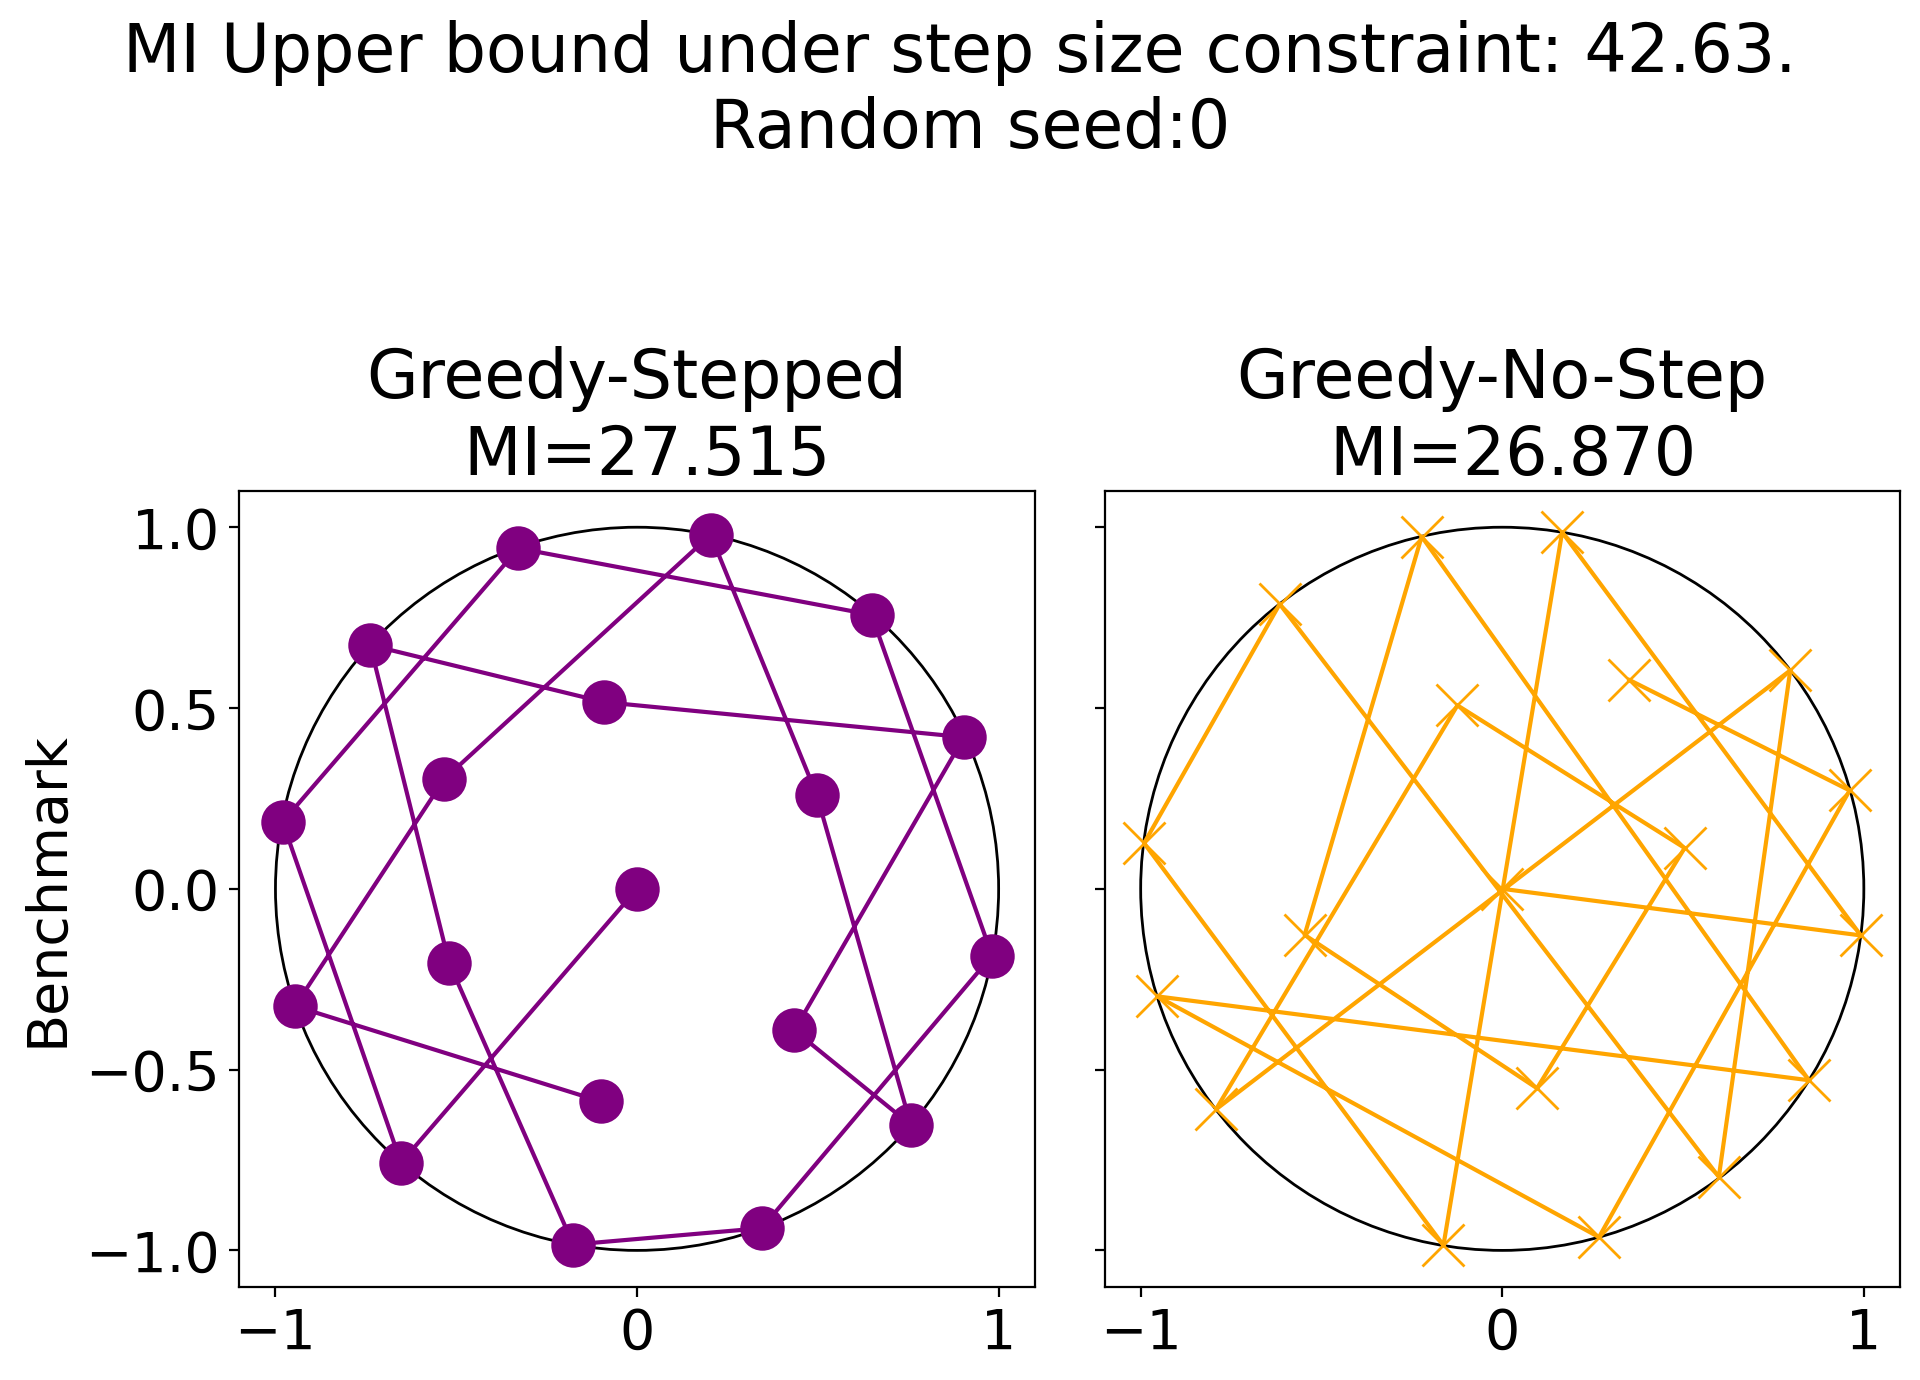

In [59]:
plt.rc('font',size=20)
fig,axes = plt.subplots(1,2,dpi=200,figsize=(10,8),sharey=True,sharex=True)

axes = axes.flatten()

for m,(key,val) in enumerate(benchmarks.items()):
    ax = axes[m]
 
    ax.plot(val[0][:,0],val[0][:,1],marker = val[3],markersize = 15,\
             alpha = val[2],
            color = val[1],)
    
    if m==0:
        ax.set_ylabel('Benchmark')
        
    ax.set_aspect('equal')

    circ = plt.Circle(search_region_center,search_region_radius,fill=False)
    ax.add_patch(circ)
    ax.set_title("{}\n MI={:.3f}".format(key,x_objective(val[0])))
    
    
  

    

# ll.labelLines(plt.gca().get_lines(),fontsize=12,zorder=3,yoffsets=1.5,align=False)
plt.suptitle('MI Upper bound under step size constraint: {:.2f}.\n Random seed:{}'.format(upper_bound,seed))

plt.tight_layout()
plt.show()